In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
import astropy.io.fits as fits
from skimage.filters import threshold_otsu
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors

%matplotlib inline
#%matplotlib widget

In [2]:
def loadStack(mask, first, last, step=1) :
    img = np.array([1.0])
    indices=np.arange(first,last+1,step)
    for idx,filenum in enumerate(indices) :
        fname=mask.format(filenum)
        hdul = fits.open(fname)
        tmp = hdul[0].data.astype(float)
        
        if (idx==0):
            img.resize(tmp.shape[0],tmp.shape[1],len(indices))
            
        img[:,:,idx]=tmp
        
    return img

In [3]:
dc=loadStack('/data/P20180255/02_rawdata/00_XCalibration/dc_{:05}.fits',1,10).astype(float).mean(axis=2);
ob=loadStack('/data/P20180255/02_rawdata/00_XCalibration/ob_{:05}.fits',1,10).astype(float).mean(axis=2);

In [4]:
ob1=ob-dc
np.nan_to_num(ob1)
ob1[ob1<=0]=1
print(dc.min(),dc.max(),dc.mean())
print(ob1.min(),ob1.max(),ob1.mean())

0.0 65535.0 3086.5029182241765
1.0 5758.699999999999 4608.000916399276


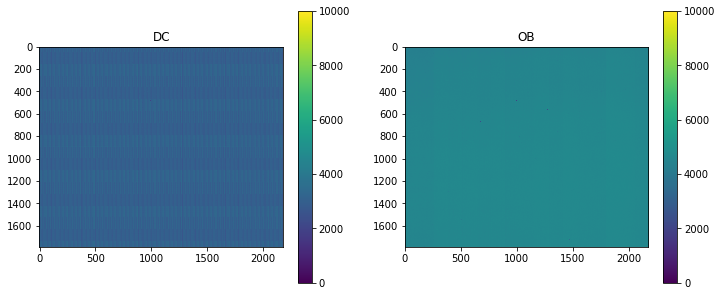

In [5]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(dc,vmax=10000,vmin=0)
plt.title('DC')
plt.colorbar()
plt.subplot(1,2,2)
ob2=ob1[450:500,975:1050]
plt.imshow(ob1,vmax=10000,vmin=0)
plt.title('OB')
plt.colorbar()

0.0 65535.0 4019.7090298152093


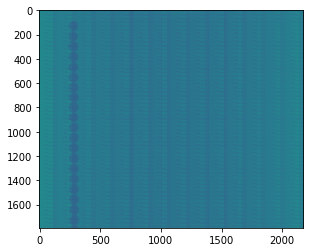

In [6]:
cal=loadStack('/data/P20180255/02_rawdata/00_XCalibration/xcal_{:05}.fits',1,361,10).astype(float)
print(cal.min(),cal.max(),cal.mean())
plt.imshow(cal[:,:,1],vmin=0.0,vmax=10000)

In [7]:
def normalizeData(img,ob,dc) :
    for idx in np.arange(0, cal.shape[2]):
        tmp=(img[:,:,idx]-dc)
        tmp[tmp<=0]=1
        img[:,:,idx]=(tmp/ob1)
    lcal=-np.log(img)
    
    return lcal

In [8]:
lcal=normalizeData(cal,ob,dc)

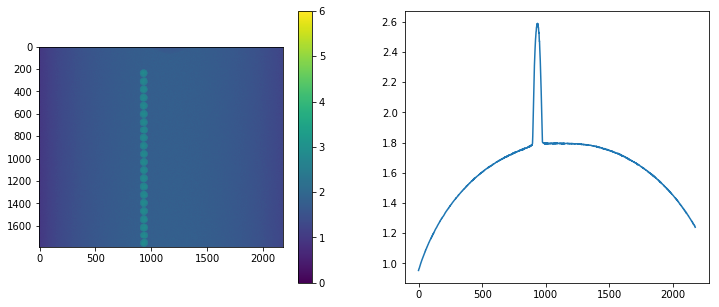

In [9]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[:,:,idx],vmin=0,vmax=6)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[:,:,idx].mean(axis=0))


In [10]:
def removeBaseline(img) :
    baseline = lcal.mean(axis=2).mean(axis=0)
    baseline=baseline.reshape(1,baseline.shape[0])

    b2=np.matmul(np.ones([lcal.shape[0],1]),baseline)
    res=img;
    for idx in np.arange(0,img.shape[2]) :
        res[:,:,idx]=res[:,:,idx]-b2
    return res

In [11]:
bcal=removeBaseline(lcal)

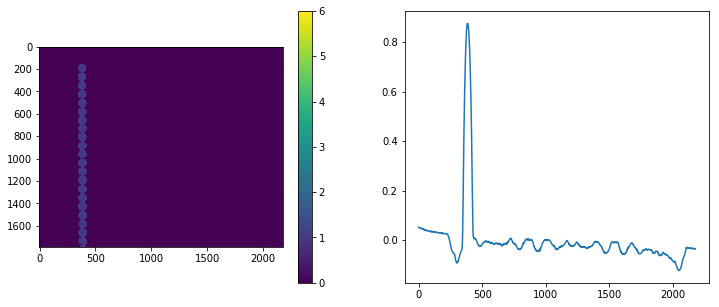

In [13]:
idx=5
m = bcal.mean()
s = bcal.std()
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(m+1.96*s < bcal[:,:,idx],vmin=0,vmax=6)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(bcal[:,:,idx].mean(axis=0))

In [14]:
def thresholdBBs(img,k) :
    s=bcal.std()
    m=bcal.mean()
    
    return (m+k*s)< img


In [15]:
tcal=thresholdBBs(bcal,1.96)

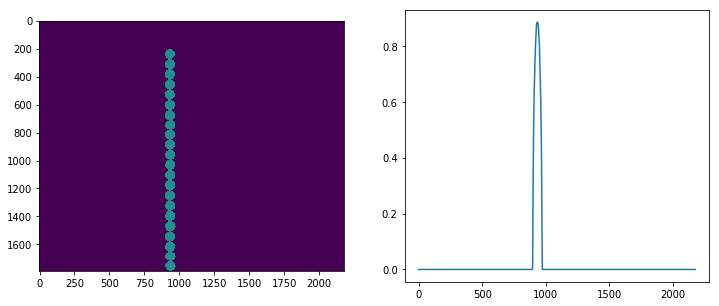

In [16]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(tcal[:,:,idx],vmin=0,vmax=2)
plt.subplot(1,2,2)
plt.plot(tcal[:,:,idx].mean(axis=0))

In [17]:
def findBeads(img) :
    distance = ndi.distance_transform_edt(img)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9)),labels=img)
    markers = ndi.label(local_maxi)[0]

    labels = watershed(-distance, markers, mask=img)
    h,ax=np.histogram(labels,bins=np.arange(0,labels.max()+1))
    m=h[np.argwhere(h<0.05*np.prod(labels.shape))].mean()
    s=h[np.argwhere(h<0.05*np.prod(labels.shape))].std()
    cog=[]
    for i in np.arange(0, h.size) :
        if ((m-s)<h[i]) and (h[i]<(m+s)) :
            selection=np.argwhere(labels==i)
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog

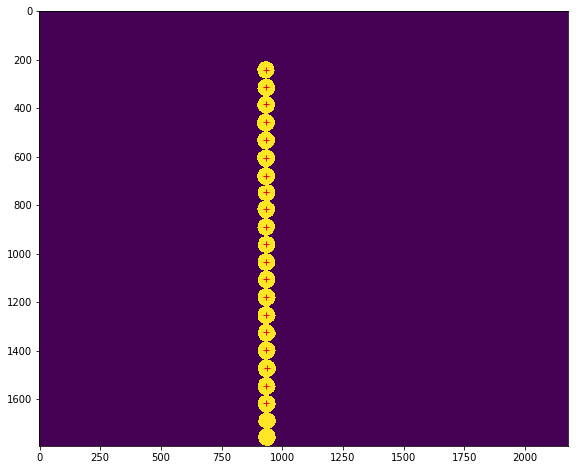

In [18]:
idx=10
cog=findBeads(tcal[:,:,idx])

plt.figure(figsize=[12,8])
plt.imshow(tcal[:,:,idx])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

In [118]:
beadlist = []
bl2 = np.array([])
for idx in np.arange(0, tcal.shape[2]) :
    cog=findBeads(tcal[:,:,idx])
    beadlist.append(cog)
    bl2=np.append(bl2,cog)
    

In [117]:
cog

array([[ 113.90221828,  324.28837622],
       [ 199.70483552,  319.83372281],
       [ 284.76842105,  325.16376186],
       [ 371.45109513,  325.27186089],
       [ 458.4182255 ,  324.88124249],
       [ 545.22469669,  326.2243643 ],
       [ 632.44078616,  326.59784982],
       [ 714.01355258,  328.32435851],
       [ 795.23884602,  326.8840993 ],
       [ 880.83033827,  327.37121212],
       [ 966.31840621,  328.18353315],
       [1051.80417931,  329.26103809],
       [1138.03963361,  328.52175445],
       [1223.78933465,  329.8036982 ],
       [1311.34571997,  330.18447246],
       [1397.44190766,  330.7170641 ],
       [1483.73700814,  331.41823012],
       [1570.55625622,  331.49618321]])

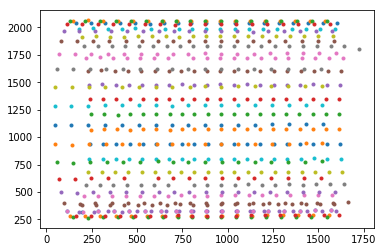

In [94]:
for bb in beadlist :
 #   print(bb.shape)
    plt.plot(bb[:,0],bb[:,1],'.')

In [22]:
beadlist[0][:,1]

array([324.19238976, 319.77509896, 325.1035554 , 325.19068365,
       324.81435686, 326.15724734, 326.57094765, 328.22806381,
       326.84148989, 327.31081319, 328.07058408, 329.17248945,
       328.44289743, 329.7656559 , 330.0774718 , 330.60625528,
       331.26748426, 331.36508199])

In [130]:
def rearrangeCOG(coglist,N) :

    resx=np.ndarray(shape=(len(coglist)*N))
    resy=np.ndarray(shape=(len(coglist)*N))

    for idx in np.arange(0,len(coglist)) :
        resx[idx*N:((idx+1)*N)]=coglist[idx][0:(N),0]
        resy[idx*N:((idx+1)*N)]=coglist[idx][0:(N),1]

    res=np.ndarray(shape=(N,2,len(coglist)))

    for idx in np.arange(0,len(beadlist)) :
        res[:,0,idx]=x[idx:idx-N:N]
        res[:,1,idx]=y[idx:idx-N:N]
        
    return res


In [131]:
res=rearrangeCOG(beadlist,N)

ValueError: could not broadcast input array from shape (36) into shape (16)

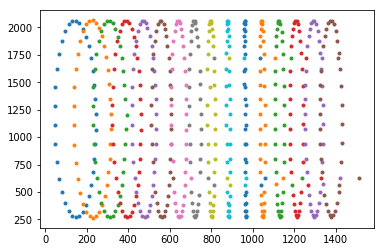

In [129]:
N=16
x,y=rearrangeCOG(beadlist,N)
for idx in np.arange(0,len(beadlist)) :
    plt.plot(x[idx:idx-N:N],y[idx:idx-N:N],'.')


In [105]:
N=17
idx=2
print(idx*N,((idx+1)*N+1),((idx+1)*N)-idx*N+1,len(beadlist[0:N]))
a=beadlist[idx][0:N,0]
a[0:17]=beadlist[0][0:17,0]
a[17:34]=beadlist[1][0:17,0]


34 52 18 17


ValueError: could not broadcast input array from shape (17) into shape (0)

In [68]:
beadlist[0][0:17,0]

array([ 113.73506401,  199.5518172 ,  284.6689679 ,  371.32272118,
        458.33814185,  545.21525931,  632.43460697,  713.78063814,
        794.96592617,  880.75727642,  966.20363508, 1051.74413502,
       1137.96898132, 1223.70682268, 1311.30275382, 1397.34573119,
       1483.64451442])

# Estimate ellipse

$\dfrac {((X-C_x)\cos(\theta)+(Y-C_y)\sin(\theta))^2}{(R_x)^2}+\dfrac{((X-C_x) \sin(\theta)-(Y-C_y) \cos(\theta))^2}{(R_y)^2}=1$

There:
- (𝐶𝑥,𝐶𝑦) is the center of the Ellipse.
- 𝑅𝑥 is the Major-Radius, and 𝑅𝑦 is the Minor-Radius.
- 𝜃 is the angle of the Ellipse rotation.

In [97]:
from skimage.measure import EllipseModel 

## Testing skimage ellipse

[10.00000000000025, 15.00000000000002, 3.9999999999977613, 8.00000000000537, 0.5235987755993301] 30.0000000001


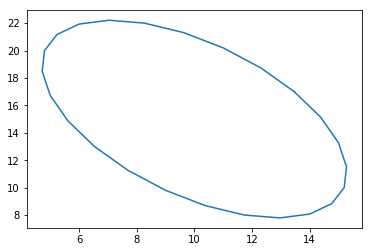

In [102]:
xy = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25),params=(10, 15, 4, 8, np.deg2rad(30)))
ellipse = EllipseModel()
ellipse.estimate(xy)
print(ellipse.params, np.rad2deg(0.5235987755993301))
plt.plot(xy[:,0],xy[:,1])

# Old stuff

In [84]:
mcal=np.median(cal[1:N:10],axis=0)

In [85]:
d0=np.mean(cal[0,10:20,10:20])
for i in np.arange(1,N) :
    di=np.mean(cal[i,10:20,10:20]) 
    cal[i]=d0/di*cal[i]

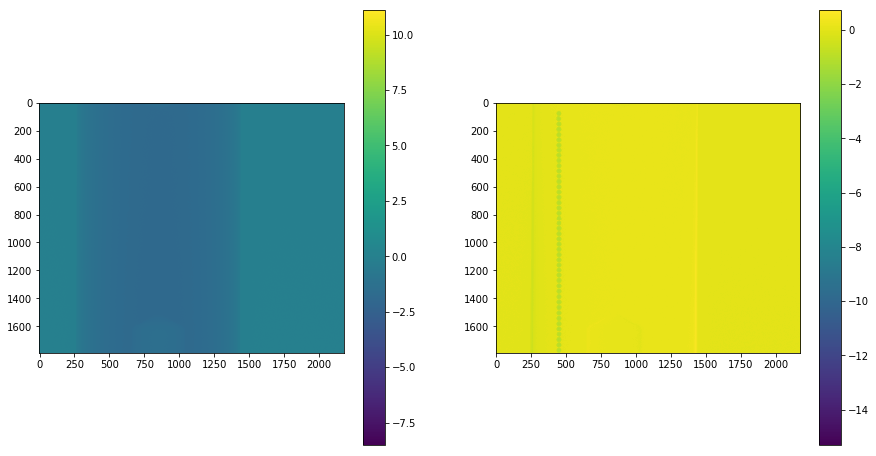

In [248]:
plt.figure(figsize=[15,8])
plt.subplot(1,2,1)
plt.imshow(mcal)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cal[1].reshape(mcal.shape)-mcal)
plt.colorbar()

In [42]:
def minmax(img) :
    print(img.min(),img.max(), img.mean(), img.std())

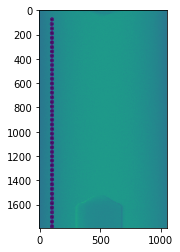

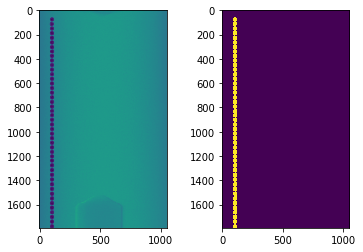

In [237]:
a=cal[4].reshape(mcal.shape)-mcal
a=a[:,350:1400]
plt.subplot(1,2,1)
plt.imshow(a)
th=threshold_otsu(a)
b=a<th
plt.subplot(1,2,2)
plt.imshow(a<th)

In [238]:
distance = ndi.distance_transform_edt(b)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9)),labels=b)
markers = ndi.label(local_maxi)[0]

labels = watershed(-distance, markers, mask=b)

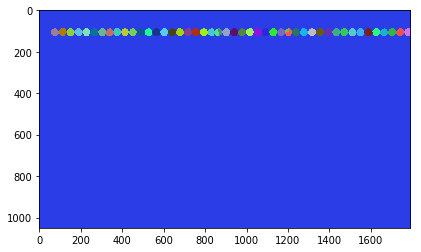

In [239]:
cmap = colors.ListedColormap ( np.random.rand ( 256,3))
plt.figure(figsize=[15,4])
plt.imshow(np.transpose(labels),cmap=cmap)

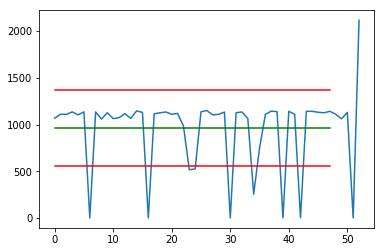

In [240]:
h,ax=np.histogram(labels,bins=np.arange(0,labels.max()+1))
plt.plot(h[1:])
plt.plot([0,47],[h[1:].mean(), h[1:].mean()],'g')
plt.plot([0,47],[h[1:].mean()-h[1:].std(), h[1:].mean()-h[1:].std()],'r')
plt.plot([0,47],[h[1:].mean()+h[1:].std(), h[1:].mean()+h[1:].std()],'r')

In [245]:
m=h[np.argwhere(h<0.1*np.prod(labels.shape))].mean()
s=h[1:].std()
print(m,s,m-s,m+s)


960.264150943 407.537712154 552.726438789 1367.8018631


In [242]:
def findBeads(img) :
    distance = ndi.distance_transform_edt(img)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((9,9)),labels=b)
    markers = ndi.label(local_maxi)[0]

    labels = watershed(-distance, markers, mask=b)
    h,ax=np.histogram(labels,bins=np.arange(0,labels.max()+1))
    m=h[np.argwhere(h<0.05*np.prod(labels.shape))].mean()
    s=h[np.argwhere(h<0.05*np.prod(labels.shape))].std()
    cog=[]
    for i in np.arange(0, h.size) :
        if ((m-s)<h[i]) and (h[i]<(m+s)) :
            selection=np.argwhere(labels==i)
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog


[[   76.22003745   106.20131086]
 [  113.59189189   104.70720721]
 [  151.4566787    106.2698556 ]
 [  189.9339207    105.96740088]
 [  228.23028105   106.01450589]
 [  266.30748899   106.36475771]
 [  304.74338624   106.30687831]
 [  340.41965974   107.35160681]
 [  376.46269982   105.88809947]
 [  413.97742239   106.13076199]
 [  451.64958062   106.61509786]
 [  489.36794987   106.57296329]
 [  527.07223265   106.53283302]
 [  564.95196507   106.64017467]
 [  603.43716814   106.54690265]
 [  641.30672646   106.72017937]
 [  678.93244444   106.456     ]
 [  717.21693122   106.76895944]
 [  755.24346258   106.77908025]
 [  793.30920465   106.66577301]
 [  829.35736041   107.01319797]
 [  901.69366197   106.72623239]
 [  940.13217391   106.6       ]
 [  977.95644283   106.97277677]
 [ 1015.33453562   106.68349865]
 [ 1052.58781995   106.51368049]
 [ 1090.73623446   106.92184725]
 [ 1128.60758377   106.58818342]
 [ 1165.96616541   106.69548872]
 [ 1204.21715818   109.41689008]
 [ 1237.11

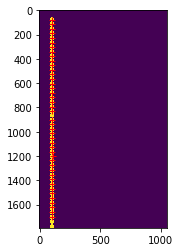

In [250]:
cog=findBeads(b)
print(cog) 
plt.figure(figsize=[15,4])
plt.imshow(b)

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

In [161]:
labels.shape

(1792, 250)

In [144]:
pos.mean(axis=0)

array([ 113.5       ,  154.69606004])